# K-Nearest Neighbors
## CSCI 4622 - 2021 Fall

For today's assignment, we will be implementing our own K-Nearest Neighbors (KNN) algorithm.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neighbors
from sklearn.model_selection import train_test_split

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*

Yes - but it also has a ton of helper functions, including a dataset we'll be using later. But first, let's also create a dataset to play with and start working to build out our own classifier.

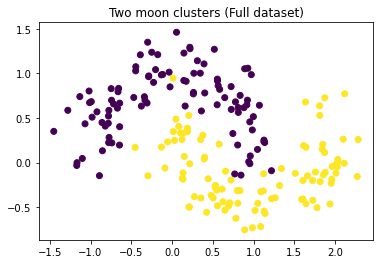

In [2]:
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.19, random_state=42)
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]
plt.title("Two moon clusters (Full dataset)")
plt.scatter(X[:,0], X[:,1], c=y)

plt.show()

We have data!

Now, let's set up a KNNClassifier class. 

The KNNClassifier class will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- Fit the classifier using the training data
- Predict the class of new points `X_test`

We've written out a lot of the structure for you so it will be consistent and we can use / reuse it, and you can focus on the "important" stuff that actually relates to the machine learning itself.

In [6]:

class KNNClassifier:

    def __init__(self, k = 5):
        """
        Initialize our custom KNN classifier
        PARAMETERS

        k - the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._model = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.counts = 0

    def fit(self, features, labels):
        """
        
        :param features: 2-D np.array of shape (number training samples, features dimension)
        :param labels: 1-D np.array of shape (number training samples,)
        :return: self
        """
        
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels
        self.counts = self.get_counts()
        
        # Should be used to map the classes to {0,1,..C-1} where C is the number of classes
        self.label_to_index = dict(zip(sorted(self.counts.keys()), range(len(self.counts))))
        self.index_to_label = dict(zip(range(len(self.counts)), sorted(self.counts.keys())))
        
        return self

    def get_counts(self):
        """
        Creates a dictionary storing the count of elements of each class
        :return: dict where the keys are the classes and values are the counts
        """

        counts = dict()
        #BEGIN Workspace 1.1
        #TODO: Modify and/or add to counts so that it returns a count of each answer class found in y

        c0_count = 0
        c1_count = 0
        
        for element in self._y:
            
            if element == 0:
                c0_count+=1
            if element == 1:
                c1_count+=1
        
        counts["0"] = c0_count
        counts["1"] = c1_count
        
        #END Workspace 1.1
        return counts

    def majority_vote(self, indices):
        """
        Given indices, report the majority label of those points.
        FOR A TIE, report the most common label in the data set.
        :param indices: indices of training neighbors of shape (M, k) where k the classifier parameter
        :return: The majority label for each set of indices, shape (M,)
        """
        
        #BEGIN Workspace 1.2
        # TODO: Determine majority, assign it to label
        
        labels = np.array([])
    
        for group in indices:
            
            l0 = 0
            l1 = 0
            
            for idx in group:
                
                if self._y[idx] == 0:
                    l0 += 1
                if self._y[idx] == 1:
                    l1 += 1
            
            if l0 > l1:
                labels = np.append(labels, [0])
                
            elif l0 < l1:
                labels = np.append(labels, [1])
                
            else:
        
                if self.counts["0"] > self.counts["1"]:
                    labels = np.append(labels, [0])
                else:
                    labels = np.append(labels, [1])
        
        #END Workspace 1.2
        
        return labels

    def predict(self, points):
        """
        Given new data points, classify then according to the training data provided in fit and number of neighbors k
        :param point: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        
        #BEGIN Workspace 1.3
        #TODO: perform classification of points here
        #HINT: use the majority function created above
        #HINT: use the euclidean distance discussed in lecture to find nearest neighbors
        
        answer = np.array([])
        
        dist, ind = self._model.query(points, k=self._k)
            
        answer = np.array(self.majority_vote(ind))
        
        #END Workspace 1.3
        return answer

    def confusion_matrix(self, features_test, labels_test):
        """
        Generate the confusion matrix for the given test data
        :param features_test: an np.array of feature vectors of test points, shape (N, n_features)
        :param labels_test: the corresponding correct classes of our test set, shape (N,)
        :return: an C*C np.array of counts, where C is the number of classes in our classifier
        """
    
        #BEGIN Workspace 1.4
        #TODO: Run classification for the test set, compare to test answers, and add counts to matrix
        
        test_classifications = self.predict(features_test)
        test_classifications = test_classifications.astype('int64')
        
        idx = -1
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        for classification in test_classifications:
            
            idx += 1
            
            if classification == labels_test[idx]: #true positive/negative
                
                if classification == 1: #true positive
                    tp += 1
                    
                else:  #true negative
                    tn += 1
            
            else:
                
                if classification == 1: #false positive
                    fp += 1
                    
                else:  #false negative
                    fn += 1
        
        c_matrix = np.array([[tp,fp],[fn,tn]])
        #END Workspace 1.4
        return c_matrix

    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = 0
        
        #BEGIN Workspace 1.5
        #TODO: Compute accuracy of the classification of X_test
        
        cm = KNNClassifier.confusion_matrix(self, features_test, labels_test)
        
        tp_tn = cm[0][0] + cm[1][1]
        fp_fn = cm[1][0] + cm[0][1]
        
        score = tp_tn/(tp_tn + fp_fn)
        #END Workspace 1.5
        return score


*But professor, this code isn't complete!*

### Problem 1: Complete our KNN Classifier - 40 Points

1.1 - Complete the `get_counts` function to return the count of each class found in the training set (5 points)

1.2 - Complete the `majority_vote` function to determine the majority class of a series of neighbors (10 points)

1.3 - Complete the `predict` function to capture the predicted class of a new datapoint (10 points)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.4 - Complete the `confusion_matrix` function to reveal the results of classification (5 points)

1.5 - Complete the `accuracy` function to get accuracy of the classifier based on a given test data (5 points)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

In [4]:
def show_decision_surface(model):
    """
    Helper function to visualize the decision surface of model
    :param model: Initialized KNNClassifier
    :return: None
    """
    
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    x_grid = np.arange(x_min, x_max, 0.1)
    y_grid = np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1,1), yy.reshape(-1,1)
    grid = np.hstack((r1,r2))
    y_hat = model.predict(grid)
    zz = y_hat.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='PiYG')
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

1.6. Try different values of k and report their accuracies and confusion matrices on the test set. Make sure to keep `random_state=42` so that the reported values don't change when code is re-run (5 points)

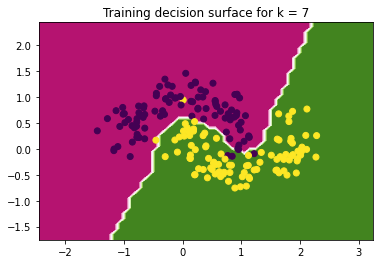

In [5]:
#BEGIN Workspace 1.6
#TODO: Try different Ks        
kk = 7
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
#END Workspace 1.6


In [70]:
# Code for 1.6
cm_test = model.confusion_matrix(X_test, y_test)

print("___Confusion Matrix___:\n")
print(cm_test)
print("\n")

accuracy_test = model.accuracy(X_test, y_test)

print("___Score___:\n")
print(accuracy_test)




___Confusion Matrix___:

[[50  2]
 [ 1 47]]


___Score___:

0.97


#### Write up for 1.6 here

### Bonus (for the avid machine learner) (10 Points)
1.7. For which value of $k$ is the classifier consistent? (Only worry about this question within our `random_state=42` constraint)

1.8. Edit your `KNNClassifier` so that it's consistent for all $k$ (This solution should work beyond our `random_state=42` constraint, but retain the constraint when submitting your code above)

For a definition of a consistent classifier, refer to [Consistent Classification, Firm and Soft by Barum](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf) (The answer is found in the abstract and introduction sections of the paper) 

#### Write up for the bonus

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

Let's be a little smart about this - let's up some classes and helper functions to help us out.

### Problem 2: Implement KNN on Digits dataset - 30 Points

2.1 **Randomly** divide our digit dataset into training and testing sets (10 Points)

2.2 Report the number of examples in training and testing, as well as measuring then number of pixels in each image (10 points)

2.3 Create a confusion matrix of our classifier for K = 5 (10 points) *HINT: Doing this may cause you to catch mistakes in your classifier. Go fix those!*

In [7]:
class Numbers:
 
    
    def __init__(self):
        #load data from sklearn
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        self.labels = data["target"]
        self.features = features.reshape(features.shape[0], -1)
    
        # BEGIN Workspace 2.1       
        x_train, x_test, y_train, y_test = train_test_split(self.features, self.labels, test_size=0.20)
        
        self.train_x = np.array(x_train) # A 2D np.array of training examples, REPLACE
        self.train_y = np.array(y_train) # A 1D np.array of training answers, REPLACE
        
        self.test_x = np.array(x_test) # A 2D np.array of testing examples, REPLACE
        self.test_y = np.array(y_test) # A 1D np.array of testing answers, REPLACE
    
        self.classifier = KNNClassifier(k=5) # KNNClassifier, REPLACE
        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier
        #END Workspace 2.1
        #print("First 10 testing labels: ", self.test_y[0],self.test_y[1],self.test_y[2],self.test_y[3],self.test_y[4],self.test_y[5],self.test_y[6],self.test_y[7],self.test_y[8],self.test_y[9], "\n")
        
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        #BEGIN Workspace 2.2
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        print("Training features set size: ", len(self.train_x))
        print(" - Datapoint size: ", len(self.train_x[0]))
        print("\n")
        
        print("Testing features set size: ", len(self.test_x))
        print(" - Datapoint size: ", len(self.test_x[0]))
        print("\n")
        
        #END Workspace 2.2
        

    def classify(self):
        """
        Fits classifier using the training data and generate a confusion matrix for the test data
        then return the confusion matrix
        """
        #BEGIN Workspace 2.3.a
        #TODO: Create classifier from training data, generate confusion matrix for test data
        
        model = self.classifier.fit(self.train_x, self.train_y)

        
        def majority(arr):
        
            answers = np.array([])
            
            for label_group in arr:
                
                values = np.array([])
                
                for idx in label_group:
                    
                    values = np.append(values, self.train_y[idx])
                
                vals,counts = np.unique(values, return_counts=True)
                index = np.argmax(counts)
                answers = np.append(answers, vals[index])
                

            return answers
            
            
            
        def pred(features):
            
            dist, ind = model._model.query(features, k=self.classifier._k)
            answer = np.array(majority(ind))
            answer = answer.astype('int64')
        
            return answer
            
            
            
        pred_ans = pred(self.test_x)
        actual_ans = self.test_y

        c_matrix = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        inc = 0
        
        #print("Misclassified test sample indexes: ")
        for pred_val in pred_ans:
            
            #if pred_val != actual_ans[inc]:
                #print(inc)
            
            c_matrix[pred_val][actual_ans[inc]] += 1
            inc += 1
            
            
        #END Workspace 2.3.a
        
        
        return  c_matrix
        
    
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = 0
        #BEGIN Workspace 2.3.b
        #TODO: Compute accuracy using confusion matrix
        
        total_hits = 0
        total_samples = 0
        
        for i in range(0,10):
            total_hits += c_matrix[i][i]
            
            for j in range(0,10):
                total_samples += c_matrix[i][j]
        
        accuracy = total_hits/total_samples
        
        #END Workspace 2.3.b
        
        return accuracy

    def view_digit(self, index):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        #TODO: process digit_image to matrix "image"
        digit_image = self.test_x[index]
        image = digit_image.reshape(8, -1)
        print("Image for digit {}".format(self.test_y[index]))
        plt.matshow(image)
        plt.show()
        
    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()
        

In [105]:
numbers = Numbers()


Training features set size:  1437
 - Datapoint size:  64


Testing features set size:  360
 - Datapoint size:  64


Misclassified test sample indexes: 
175
202
205
212
230
260
335


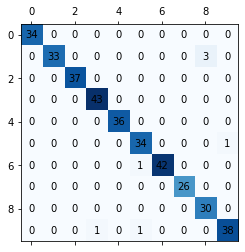

In [106]:
numbers.report()
#numbers.view_digit(9)
cm = numbers.classify()
numbers.display_confusion(cm)

In [107]:
numbers.accuracy()

Misclassified test sample indexes: 
175
202
205
212
230
260
335


0.9805555555555555

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore that issue a little further by turning the $K$ and random split knobs

### Problem 3: Improving KNN on Digits - 30 Points

3.1 Determine which classes are most often confused (from our confusion matrix above), inspect some examples of these digits (using the `view_digit` function in our Numbers class), and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (10 pts)

3.2 Explore the influence of the number of nearest neighbors (i.e. try changing our K). Plot the relationship between K and accuracy, and write a brief (4 - 5 sentences) description of how this factor impacts our accuracy. To mitigate the effect of randomness from the split, you have to run the evaluation multiple times and report the mean accuracy. Make sure the runs for different Ks are done on the same splits. (10 pts)

3.3 Explore the influence of the train / test split of our data (i.e. copy our Numbers class into Numbers2 below and try changing the split for our dataset). Plot the relationship between the split % and accuracy, and write a brief (4 - 5 sentences) description of its impact. (10 pts)

You can complete the `NumbersKnobs` class and use it as you see fit. But it's only necessary for 3.3

Image for digit 8


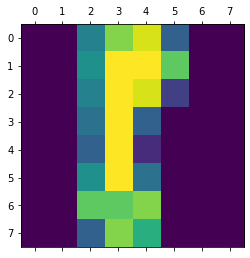

Image for digit 8


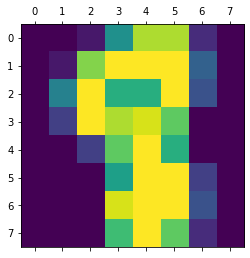

Image for digit 8


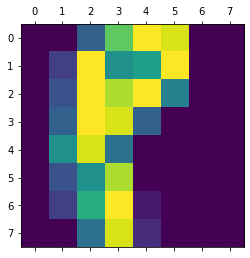

In [111]:
#BEGIN 3.1a
#TODO: Print out problem class images

numbers.view_digit(175)
numbers.view_digit(205)
numbers.view_digit(212)

#END 3.1a

#### 3.1b
On my last run of the classifier, the most misclassified class was the one belonging to the digit 8. From the test samples, 3 samples (indexes 175, 205, and 212) got misclassified for the digit 1 instead of the digit 8. When looking at the images of the misclassified samples it did not suprise me they were misclassified because the three hardly resemble the digit 8. The previous can be more clearly seen when looking at the testing sample with index 175. If I was given the image for that sample I would say it looks like the digit 1 with a good level of confidence. Ultimately, I'd argue that this classifier does a good job at classifying digits which contain the right features representing their respective class.

In [8]:
#BEGIN 3.2a
#TODO: Run evaluation for different K and plot K vs Accuracy

class Numbers2:
 
    
    def __init__(self, x_train, x_test, y_train, y_test, kk):
        
        self.train_x = np.array(x_train) # A 2D np.array of training examples, REPLACE
        self.train_y = np.array(y_train) # A 1D np.array of training answers, REPLACE
        
        self.test_x = np.array(x_test) # A 2D np.array of testing examples, REPLACE
        self.test_y = np.array(y_test) # A 1D np.array of testing answers, REPLACE

        self.classifier = KNNClassifier(k=kk) # KNNClassifier, REPLACE
        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier
        #END Workspace 2.1
        #print("First 10 testing labels: ", self.test_y[0],self.test_y[1],self.test_y[2],self.test_y[3],self.test_y[4],self.test_y[5],self.test_y[6],self.test_y[7],self.test_y[8],self.test_y[9], "\n")
        

    def classify(self):
        """
        Fits classifier using the training data and generate a confusion matrix for the test data
        then return the confusion matrix
        """
        #BEGIN Workspace 2.3.a
        #TODO: Create classifier from training data, generate confusion matrix for test data
        
        model = self.classifier.fit(self.train_x, self.train_y)

        
        def majority(arr):
        
            answers = np.array([])
            
            for label_group in arr:
                
                values = np.array([])
                
                for idx in label_group:
                    
                    values = np.append(values, self.train_y[idx])
                
                vals,counts = np.unique(values, return_counts=True)
                index = np.argmax(counts)
                answers = np.append(answers, vals[index])
                

            return answers
            
            
            
        def pred(features):
            
            dist, ind = model._model.query(features, k=self.classifier._k)
            answer = np.array(majority(ind))
            answer = answer.astype('int64')
        
            return answer
            
            
            
        pred_ans = pred(self.test_x)
        actual_ans = self.test_y

        c_matrix = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        inc = 0
        
        for pred_val in pred_ans:
            
            c_matrix[pred_val][actual_ans[inc]] += 1
            inc += 1
            
            
        #END Workspace 2.3.a
        
        
        return  c_matrix
        
    
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = 0
        #BEGIN Workspace 2.3.b
        #TODO: Compute accuracy using confusion matrix
        
        total_hits = 0
        total_samples = 0
        
        for i in range(0,10):
            total_hits += c_matrix[i][i]
            
            for j in range(0,10):
                total_samples += c_matrix[i][j]
        
        accuracy = total_hits/total_samples
        
        #END Workspace 2.3.b
        
        return accuracy
    

In [12]:
data2 = sklearn.datasets.load_digits()
features1 = data2["data"]
labels2 = data2["target"]
features2 = features1.reshape(features1.shape[0], -1)

mean_accuracies = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
kk = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

for i in range(0,50):

    x_train2, x_test2, y_train2, y_test2 = train_test_split(features2, labels2, test_size=0.20)
    
    for k in kk:
        numbers2 = Numbers2(x_train2, x_test2, y_train2, y_test2, k)
        accuracy = numbers2.accuracy()
        #print(accuracy, k)
        mean_accuracies[k-1] += accuracy

for i in range(0,30):
    mean_accuracies[i] = mean_accuracies[i]/50

print(mean_accuracies)


#END 3.2a

[0.98788889 0.98611111 0.98794444 0.986      0.98655556 0.984
 0.98466667 0.98216667 0.98227778 0.98116667 0.98138889 0.97961111
 0.979      0.97738889 0.97666667 0.97505556 0.974      0.97327778
 0.97177778 0.97088889 0.96955556 0.96816667 0.96722222 0.96566667
 0.96527778 0.96455556 0.96377778 0.96305556 0.96261111 0.96216667]


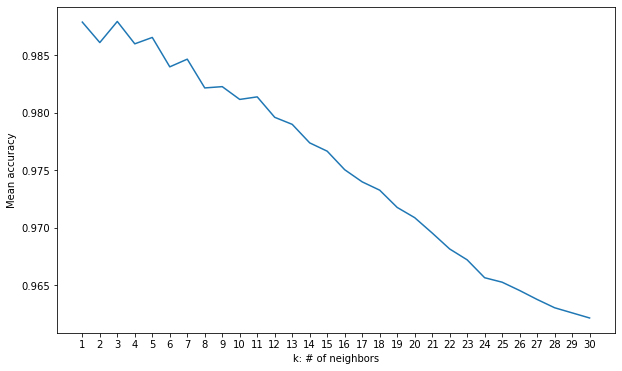

In [17]:
plt.figure(figsize=(10,6))
plt.plot(kk, mean_accuracies)
plt.xlabel('k: # of neighbors')
plt.ylabel('Mean accuracy')
plt.xticks(range(1,31))
plt.show()

#### 3.2b
In order to make this answer work, I had to redefine our numbers class (-I needed to change the paremeters of __init__) to be able to change the values of k and to be able use the same split of data for different values of k on the same iteration of the outside loop. (-the outside loop is done 50 times to then take the average of different k's accuracies on same splits.) 

By looking at the plot, one could argue that the more neighbors we take into account, the less accurate our KNN classifier is going to be. I was a bit suprised to see that k=1 and k=3 were the most accurate. After doing some research, I found that a possible reason for this behaviour could be that our test and training data sets are very similar or that the boundaries between classes are very clear/marked.

In [8]:

class NumbersKnobs(Numbers):
    """ Inherits from Numbers, so feel free to use methods from Numbers
    """

    def __init__(self, k=5, train_ratio=0.8):
        #load data from sklearn
        self._k = k
        self.train_ratio = train_ratio
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        labels = data["target"]
        features = features.reshape(features.shape[0], -1)
    
        x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=1 - self.train_ratio)

        #BEGIN Workspace 3.3a
        self.train_x = np.array(x_train) # A 2D np.array of training examples, REPLACE
        self.train_y = np.array(y_train) # A 1D np.array of training answers, REPLACE
        self.test_x = np.array(x_test) # A 2D np.array of testing examples, REPLACE
        self.test_y = np.array(y_test) # A 1D np.array of testing answers, REPLACE
        self.classifier = KNNClassifier(k=self._k) # KNNClassifier, REPLACE
        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier
        #TODO: Divide our dataset into Train and Test datasets (using trainPercentage), replacing the variables above
        #HINT: You should be able to mostly copy your own work from the original Numbers class
        #END Workspace 3.3a


0.5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.7: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.8: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.9: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,


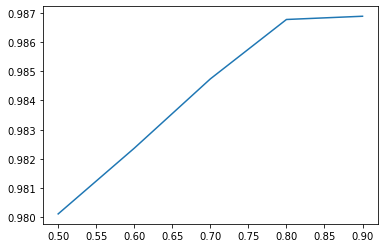

In [11]:
#BEGIN Workspace 3.3b
#TODO: analyze the effect of split ratio
k = 5
repetitions = 25 # Feel free to increase it
split_ratios = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
results = np.zeros((len(split_ratios),repetitions))

for i, s in enumerate(split_ratios):
    print(s ,end =": ")
    
    for j in range(repetitions):
        print(j, end=",")
        
        numbers = NumbersKnobs(k=k, train_ratio=s)
        results[i,j] = numbers.accuracy() # TODO get accuracy of classification
        
    print("")
# Add title axis labels to the plot

plt.plot(split_ratios, results.mean(1))

#END Workspace 3.3b

#### 3.3b
By looking at the plot, one could argue that the accuracy does not increase after the 80/20 split ratio mark. I ran the code for 3.3 multiple times and some of the times the accuracy actually would decrese after the 80/20 split ratio mark. Therefore, I think that 80% training and 20% testing is where accuracy actually peaks in terms of split ratio.